In [22]:
%matplotlib inline
import matplotlib.pylab as plt
import future.utils
import networkx as nx
import numpy as np
import random
from ndlib.models.DiffusionModel import DiffusionModel
import ndlib.models.ModelConfig as mc
from bokeh.io import output_notebook, show
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
output_notebook()

Loading BokehJS ...

In [23]:
class SIRSESIRModel(DiffusionModel):
    """
       Model Parameters to be specified via ModelConfig
       :param beta: The infection rate (float value in [0,1])
       :param gamma: The recovery rate (float value in [0,1])
    """

    def __init__(self, graph):
        """
             Model Constructor
             :param graph: A networkx graph object
         """
        super(self.__class__, self).__init__(graph)
        self.available_statuses = {
            "S1": 0,"Infected": 1,"R1": 2,
            "S0":3,"E1":4,"E2":5,
            "S2": 6,"I2": 7,"R2": 8
        }

        self.parameters = {
            "model": {
                "beta": {
                    "descr": "Infection rate",
                    "range": [0, 1],
                    "optional": False},
                "gamma": {
                    "descr": "Recovery rate",
                    "range": [0, 1],
                    "optional": False},
                "epsilon": {
                    "descr": "Recovery rate",
                    "range": [0, 1],
                    "optional": False},
                "tp_rate": {
                    "descr": "Whether if the infection rate depends on the number of infected neighbors",
                    "range": [0, 1],
                    "optional": True,
                    "default": 1
                }
            },
            "nodes": {},
            "edges": {},
        }

        self.name = "SIRSESIR"

    def iteration(self, node_status=True):
        """
        Execute a single model iteration
        :return: Iteration_id, Incremental node status (dictionary node->status)
        """
        self.clean_initial_status(self.available_statuses.values())

        actual_status = {node: nstatus for node, nstatus in future.utils.iteritems(self.status)}

        if self.actual_iteration == 0:
            self.actual_iteration += 1
            delta, node_count, status_delta = self.status_delta(actual_status)
            if node_status:
                return {"iteration": 0, "status": actual_status.copy(),
                        "node_count": node_count.copy(), "status_delta": status_delta.copy()}
            else:
                return {"iteration": 0, "status": {},
                        "node_count": node_count.copy(), "status_delta": status_delta.copy()}

        for u in self.graph.nodes:

            u_status = self.status[u]
            eventp = np.random.random_sample()
            neighbors = self.graph.neighbors(u)
            if self.graph.directed:
                neighbors = self.graph.predecessors(u)
            # If from the 1 camp
            if u_status == 0:
                infected_neighbors = [v for v in neighbors if self.status[v] == 1]
                triggered = 1 if len(infected_neighbors) > 0 else 0

                if self.params['model']['tp_rate'] == 1:
                    if eventp < 1 - (1 - self.params['model']['beta']) ** len(infected_neighbors):
                        actual_status[u] = 1
                else:
                    if eventp < self.params['model']['beta'] * triggered:
                        actual_status[u] = 1
                        
            elif u_status == 1:
                if eventp < self.params['model']['gamma']:
                    actual_status[u] = 2
                    
            # If from the 0 camp                    
            elif u_status == 3:
                pro_infected_neighbors = [v for v in neighbors if self.status[v] == 1]
                anti_infected_neighbors = [v for v in neighbors if self.status[v] == 7]
                pro_triggered = 1 if len(pro_infected_neighbors) > 0 else 0
                anti_triggered = 1 if len(anti_infected_neighbors) > 0 else 0
                
                if len(pro_infected_neighbors)>len(anti_infected_neighbors):
                    if self.params['model']['tp_rate'] == 1:
                        if eventp < 1 - (1 - self.params['model']['epsilon']) ** len(pro_infected_neighbors):
                            actual_status[u] = 4
                    else:
                        if eventp < self.params['model']['epsilon'] * pro_triggered:
                            actual_status[u] = 4
                elif len(pro_infected_neighbors)<len(anti_infected_neighbors):
                    if self.params['model']['tp_rate'] == 1:
                        if eventp < 1 - (1 - self.params['model']['epsilon']) ** len(anti_infected_neighbors):
                            actual_status[u] = 5
                    else:
                        if eventp < self.params['model']['epsilon'] * anti_triggered:
                            actual_status[u] = 5
                        
            # If from the 2 camp                        
            elif u_status == 6:
                infected_neighbors = [v for v in neighbors if self.status[v] == 7]
                triggered = 1 if len(infected_neighbors) > 0 else 0

                if self.params['model']['tp_rate'] == 1:
                    if eventp < 1 - (1 - self.params['model']['beta']) ** len(infected_neighbors):
                        actual_status[u] = 1
                else:
                    if eventp < self.params['model']['beta'] * triggered:
                        actual_status[u] = 1
                        
            elif u_status == 7:
                if eventp < self.params['model']['gamma']:
                    actual_status[u] = 8

        delta, node_count, status_delta = self.status_delta(actual_status)
        self.status = actual_status
        self.actual_iteration += 1

        if node_status:
            return {"iteration": self.actual_iteration - 1, "status": delta.copy(),
                    "node_count": node_count.copy(), "status_delta": status_delta.copy()}
        else:
            return {"iteration": self.actual_iteration - 1, "status": {},
                    "node_count": node_count.copy(), "status_delta": status_delta.copy()}

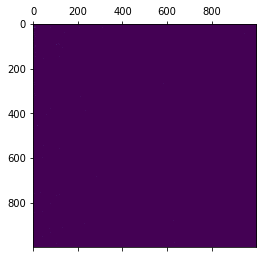

In [24]:
G = nx.scale_free_graph(1000, seed=2)
plt.matshow(nx.convert_matrix.to_numpy_matrix(G))

In [25]:
model = SIRSESIRModel(G)

In [18]:
print(dir(model.graph.nodes()))
print(model.graph.nodes())
print(model.parameters['nodes'])

['__abstractmethods__', '__and__', '__call__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__or__', '__rand__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__rsub__', '__rxor__', '__setattr__', '__setstate__', '__sizeof__', '__slots__', '__str__', '__sub__', '__subclasshook__', '__xor__', '_abc_impl', '_from_iterable', '_hash', '_nodes', 'data', 'get', 'isdisjoint', 'items', 'keys', 'values']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 8

In [19]:
for u in model.graph.nodes():
    print(model.status[u])
    print(model.graph.neighbors(u))

0
[1, 0]
0
[2, 3, 42, 0]
0
[0, 3, 2, 6, 25, 33, 54, 11, 4, 71, 79, 88, 47]
0
[]
0
[0, 2, 3, 1, 11, 20]
0
[2, 6, 4, 0, 41, 59, 76, 10, 22]
0
[]
0
[0, 6, 1, 2, 11, 78, 83]
0
[0, 2, 3, 4, 11]
0
[0, 2, 9, 4]
0
[4, 11, 2, 5]
0
[]
0
[3, 0]
0
[1]
0
[6, 9, 39]
0
[11, 0]
0
[2, 39]
0
[6]
0
[3]
0
[0, 5, 39, 61, 35, 3]
0
[2, 6]
0
[3]
0
[11]
0
[5]
0
[1]
0
[]
0
[2]
0
[0, 54]
0
[19]
0
[3]
0
[0]
0
[0, 19]
0
[3]
0
[]
0
[2, 1, 6]
0
[0]
0
[0]
0
[2]
0
[18]
0
[]
0
[2]
0
[]
0
[4, 3]
0
[1, 4]
0
[3]
0
[0]
0
[28, 3, 0]
0
[6, 9]
0
[3]
0
[2]
0
[0]
0
[2]
0
[2, 3]
0
[2]
0
[]
0
[1]
0
[3, 0]
0
[2]
0
[54]
0
[]
0
[3]
0
[]
0
[2]
0
[3, 6, 0]
0
[0]
0
[1]
0
[2]
0
[11]
0
[4]
0
[3]
0
[1]
0
[]
0
[0, 6]
0
[35]
0
[0]
0
[32, 0]
0
[]
0
[0]
0
[]
0
[]
0
[2]
0
[44]
0
[2]
0
[1]
0
[1, 87]
0
[3]
0
[2]
0
[]
0
[]
0
[2]
0
[0]
0
[5]
0
[79]
0
[2]
0
[0]
0
[0]
0
[0]
0
[4]
0
[20]
0
[2]


In [27]:
config = mc.Configuration()
config.add_model_parameter('beta', 10.0)
config.add_model_parameter('epsilon', 1000.0)
config.add_model_parameter('gamma', 1/4.2)
config.add_model_parameter("fraction_infected", 0.05)
model.set_initial_status(config)
iterations = model.iteration_bunch(200)
trends = model.build_trends(iterations)

In [28]:
viz = DiffusionTrend(model, trends)
#viz.plot("diffusion.pdf")
p = viz.plot(width=800, height=400)
show(p)